In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DE SINAIS (ENTRADA COLORIDA COMPLEXA) ---
np.random.seed(42)
n_samples = 5000
order = 7  # M=7 (8 taps)

# Criando entrada correlacionada (Filtro AR Complexo)
# Isso cria "picos" no espectro que dificultariam o LMS comum
b_ar = [1]
a_ar = [1, -0.8 + 0.6j] # Polo complexo para colorir o ruído
x_white = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)
x = signal.lfilter(b_ar, a_ar, x_white)
x /= np.std(x)

# Planta Desconhecida Complexa
w_true = np.array([0.2+0.1j, -0.5+0.3j, 0.4-0.2j, 0.1+0.4j, 
                   -0.3-0.1j, 0.2+0.2j, 0.1-0.1j, -0.05+0.05j])

d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.02 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO T-DOMAIN DFT ---
# gamma: regularização (estabilidade)
# alpha: suavização da potência (0.01 a 0.1)
filt_dft = pdf.TDomainDFT(
    filter_order=order,
    gamma=1e-3,
    alpha=0.1,
    initial_power=1.0,
    step_size=0.08
)

result = filt_dft.optimize(x, d, verbose=True, return_internal_states=True)

[TDomainDFT] Completed in 67.827 ms


In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_fancy_adaptive_results(result, w_true, title="Adaptive Filter Analysis"):
    sns.set_theme(style="whitegrid")
    
    # Extração segura de dados
    mse = result.mse()
    # Alguns objetos usam 'w_history' ou 'coefficients'. 
    # Baseado no seu print, 'coefficients' está funcionando.
    coeffs = result.coefficients[1:] 
    errors = result.errors
    t = np.arange(len(mse))
    offset = 50

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, width_ratios=[3, 1], height_ratios=[1, 1, 1])
    
    # --- A. CURVA DE APRENDIZADO ---
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(x=t[offset:], y=mse[offset:], ax=ax1, color="skyblue", alpha=0.3)
    mse_df = pd.DataFrame({'Iter': t, 'MSE': mse})
    mse_df['Smooth'] = mse_df['MSE'].rolling(window=50).mean()
    sns.lineplot(x='Iter', y='Smooth', data=mse_df.iloc[offset:], ax=ax1, color="dodgerblue", lw=2)
    ax1.set_yscale('log')
    ax1.set_title(f"{title} - Learning Curve", fontweight='bold')

    # --- B. PDF DO ERRO ---
    ax2 = fig.add_subplot(gs[0, 1])
    # Usando apenas a parte real para o histograma se for complexo
    sns.histplot(y=np.real(errors[-500:]), kde=True, ax=ax2, color="green")
    ax2.set_title("Erro Residual (PDF)")

    # --- C. COEFICIENTES ---
    ax3 = fig.add_subplot(gs[1, :])
    palette = sns.color_palette("husl", coeffs.shape[1])
    for i in range(coeffs.shape[1]):
        sns.lineplot(x=t, y=np.real(coeffs[:, i]), ax=ax3, color=palette[i], label=f'$w_{i}$')
        ax3.axhline(y=np.real(w_true[i]), color=palette[i], linestyle='--', alpha=0.5)
    ax3.set_title("Evolução dos Coeficientes (Parte Real)")
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # --- D. CONSTELAÇÃO OU ERRO NO TEMPO ---
    ax4 = fig.add_subplot(gs[2, 0])
    if np.iscomplexobj(errors):
        ax4.hexbin(np.real(errors[-1000:]), np.imag(errors[-1000:]), gridsize=30, cmap='Blues', mincnt=1)
        ax4.set_title("Constelação do Erro (Regime Permanente)")
    else:
        ax4.plot(t, errors, color="indianred", lw=0.5)
        ax4.set_title("Erro no Tempo")

    # --- E. MÉTRICAS FINAIS (CORRIGIDO) ---
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('off')
    
    # Cálculo manual do MSE final para evitar dependência de atributos
    final_mse_val = np.mean(mse[-100:])
    final_mse_db = 10 * np.log10(final_mse_val) if final_mse_val > 0 else -np.inf
    
    stats_text = (
        f"Métricas Finais:\n"
        f"----------------\n"
        f"MSE Final: {final_mse_db:.2f} dB\n"
        f"Taps: {len(w_true)}\n"
        f"Amostras: {len(mse)}"
    )
    # Removido o emoji que causou o Warning de Glyph no seu console
    ax5.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray'))

    plt.tight_layout()
    return fig

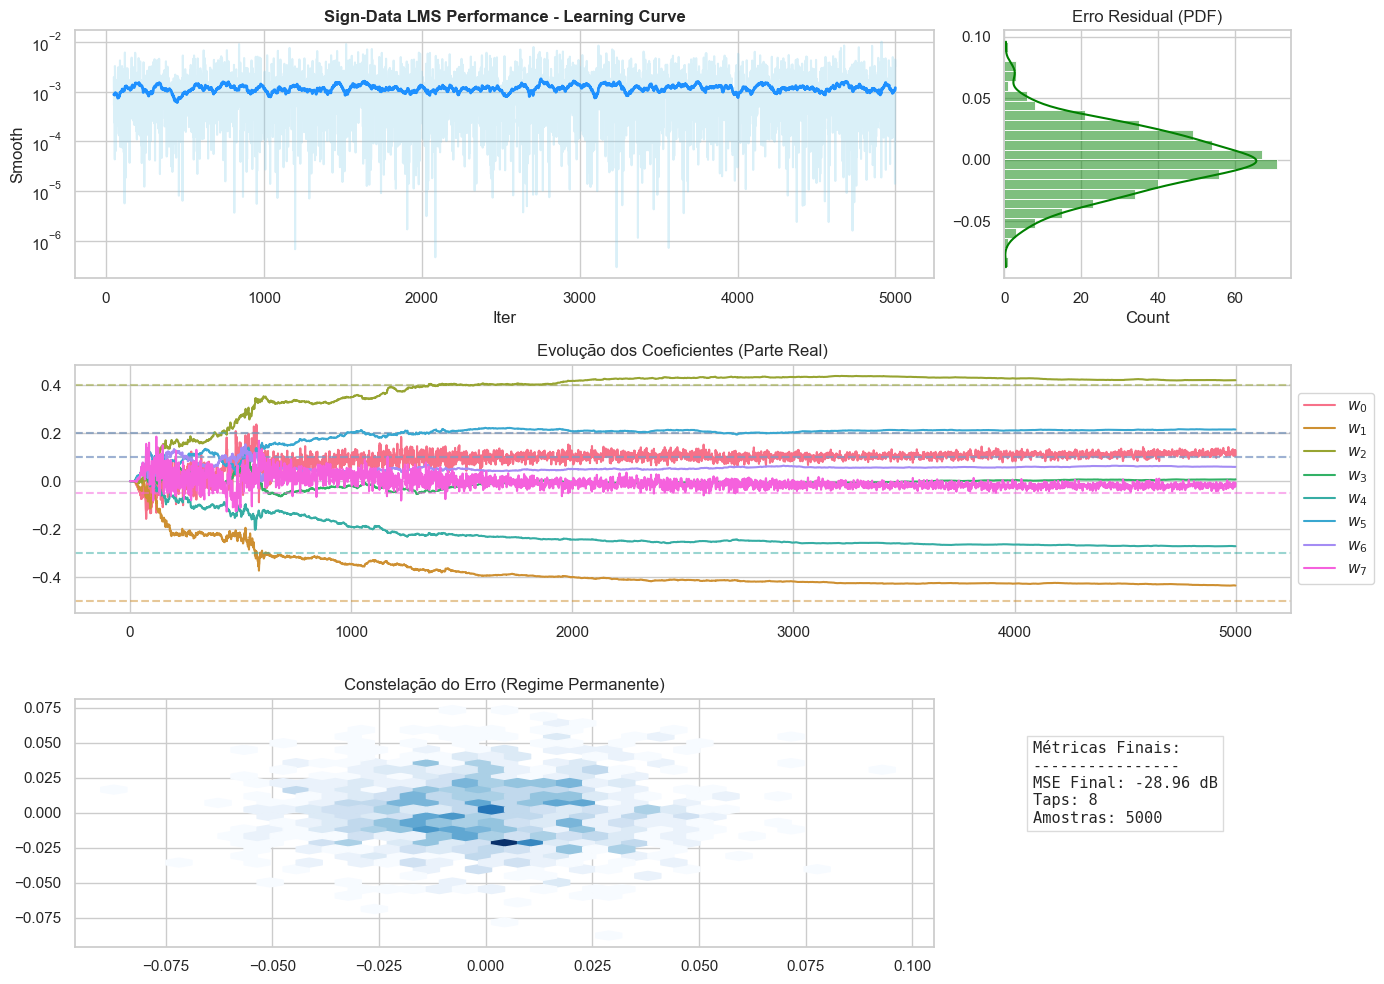

In [4]:
fig = plot_fancy_adaptive_results(result, w_true, title="Sign-Data LMS Performance")

plt.show()